In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from config import PGHOST, PGDATABASE, PGUSER, PGPASSWORD

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM

In [2]:
# Define a function to connect to AWS database instance

def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+PGHOST +" port="+ "5432" +" dbname="+PGDATABASE +" user=" + PGUSER \
                  +" password="+ PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

In [3]:
conn, cursor = connect()

Connected!


In [4]:
# Get the data, read SQL query into data frame
bb_data = pd.read_sql_query("SELECT * FROM blackberry", con=conn)
bb_df = pd.DataFrame(bb_data)
bb_df.head()

,Date,open_price,high_price,low_price,close_price,adj_close,volume
0,1999-02-04,2.145833,2.166667,1.895833,1.924479,1.924479,16788600
1,1999-02-05,1.929688,1.947917,1.822917,1.833333,1.833333,3053400
2,1999-02-08,1.854167,1.927083,1.783854,1.812500,1.812500,1548000
3,1999-02-09,1.822917,1.833333,1.656250,1.666667,1.666667,3501600
4,1999-02-10,1.708333,1.708333,1.604167,1.677083,1.677083,1597200


In [5]:
# Get the data, read SQL query into data frame
gg_data = pd.read_sql_query("SELECT * FROM google", con=conn)
gg_df = pd.DataFrame(gg_data)
gg_df.head()

,Date,open_price,high_price,low_price,close_price,adj_close,volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044


In [6]:
# Get the data, read SQL query into data frame
nf_data = pd.read_sql_query("SELECT * FROM netflix", con=conn)
nf_df = pd.DataFrame(nf_data)
nf_df.head()

,Date,open_price,high_price,low_price,close_price,adj_close,volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [7]:
# Check the rows and columns of dfs
print(bb_df.shape)
print(gg_df.shape)
print(nf_df.shape)

(5945, 7)
(4553, 7)
(5117, 7)


In [8]:
# Check if there is null values
bb_df.isnull().sum()

Date           0
open_price     0
high_price     0
low_price      0
close_price    0
adj_close      0
volume         0
dtype: int64

In [9]:
# Check the data types in df
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         5945 non-null   object 
 1   open_price   5945 non-null   float64
 2   high_price   5945 non-null   float64
 3   low_price    5945 non-null   float64
 4   close_price  5945 non-null   float64
 5   adj_close    5945 non-null   float64
 6   volume       5945 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 325.2+ KB


In [10]:
gg_df.isnull().sum()

Date           0
open_price     0
high_price     0
low_price      0
close_price    0
adj_close      0
volume         0
dtype: int64

In [11]:
nf_df.isnull().sum()

Date           0
open_price     0
high_price     0
low_price      0
close_price    0
adj_close      0
volume         0
dtype: int64

In [12]:
# Change [Date] data type to data time

bb_df['Date'] = pd.to_datetime(bb_df.Date)
gg_df['Date'] = pd.to_datetime(gg_df.Date)
nf_df['Date'] = pd.to_datetime(nf_df.Date)

In [13]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5945 non-null   datetime64[ns]
 1   open_price   5945 non-null   float64       
 2   high_price   5945 non-null   float64       
 3   low_price    5945 non-null   float64       
 4   close_price  5945 non-null   float64       
 5   adj_close    5945 non-null   float64       
 6   volume       5945 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 325.2 KB


In [14]:
# Delete 'Adj Close' column and check df

bb_df = bb_df.drop('adj_close', axis=1)
gg_df = gg_df.drop('adj_close', axis=1)
nf_df = nf_df.drop('adj_close', axis=1)

In [15]:
bb_df.set_index('Date')
gg_df.set_index('Date')
nf_df.set_index('Date')

,open_price,high_price,low_price,close_price,volume
Date,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,104790000
2002-05-24,1.214286,1.225000,1.197143,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,10154200
...,...,...,...,...,...
2022-09-13,226.500000,227.690000,217.720000,218.130000,8000100
2022-09-14,219.820000,228.000000,215.800000,224.120000,8230300
2022-09-15,230.470000,242.290000,229.100000,235.380000,19454100


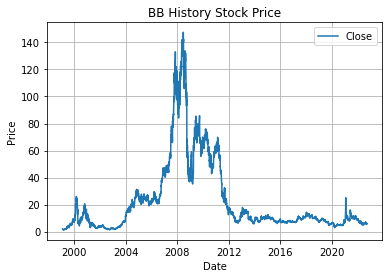

In [16]:
# Vistulize the stock price trend by using 'Close' column
plt.plot(bb_df['Date'], bb_df['close_price'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BB History Stock Price')
plt.grid()
plt.legend()
plt.show()

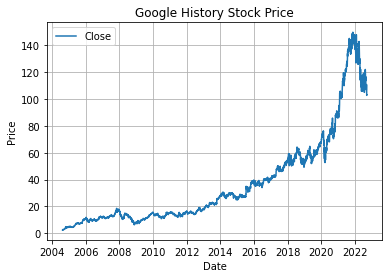

In [17]:
# Vistulize the stock price trend by using 'Close' column
plt.plot(gg_df['Date'], gg_df['close_price'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Google History Stock Price')
plt.grid()
plt.legend()
plt.show()

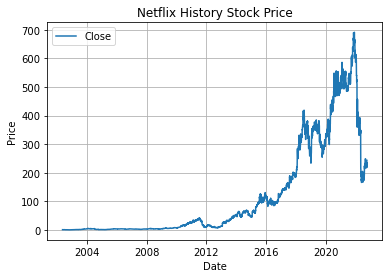

In [18]:
# Vistulize the stock price trend by using 'Close' column
plt.plot(nf_df['Date'], nf_df['close_price'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Netflix History Stock Price')
plt.grid()
plt.legend()
plt.show()

# Multiple Linear Regression Model

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [20]:
# Split our preprocessed data into our features and target arrays

X = bb_df[['open_price','high_price','low_price','volume']].values
y = bb_df['close_price'].values

In [21]:
# Split the preprocessed data into a training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [22]:
# Check the shape of X_train and X_test

print(X_train.shape)
print(X_test.shape)

(4458, 4)
(1487, 4)


In [23]:
# Build linear reg model

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [24]:
# Check the model score

lr_model.score(X_train, y_train)

0.9997635230910699

In [25]:
# Make stock price prediction

prediction = lr_model.predict(X_test)

print(prediction.shape)
print(prediction)

(1487,)
[ 7.07024107  9.91884785 62.05358664 ...  2.62858694 20.86661344
 22.28151238]


In [26]:
# Compare y_test and our prediction value

pred_df = pd.DataFrame({'Actual Price':y_test, 'Predicted Price':prediction})

pred_df.head(20)

,Actual Price,Predicted Price
0,7.050000,7.070241
1,9.880000,9.918848
2,62.410000,62.053587
3,7.430000,7.441019
4,21.630000,21.906761
5,6.200000,6.175861
6,140.840000,139.526198
7,7.940000,7.900663
8,2.983333,2.742798
9,8.430000,8.473819


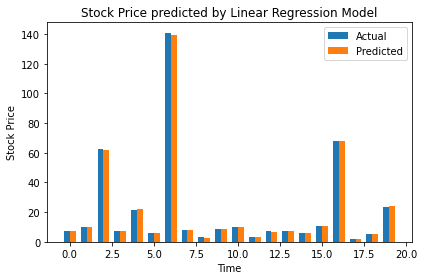

In [27]:
# Plot the actual and predicted price
# from the above data frame, we can see the difference between 'actual price' and 'predicted price' is tiny
# if using line graph, the two lines will be overlapped to each other.
# so we choose to use bar graph to show the difference of first 20 rows of data frame

fig_df = pred_df.loc[pred_df.index<20]

x = np.arange(len(fig_df['Actual Price']))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fig_df['Actual Price'], width, label='Actual')
rects2 = ax.bar(x + width/2, fig_df['Predicted Price'], width, label='Predicted')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_title('Stock Price predicted by Linear Regression Model')
ax.legend()
fig.tight_layout()
plt.show()

In [28]:
print(lr_model.coef_)
print(lr_model.intercept_)

[-6.04633013e-01  8.49151347e-01  7.54209287e-01 -1.14024046e-09]
-0.0010973939316194503


In [29]:
# Calculate the MSE for our model
# The mean squared error (MSE) tells you how close a regression line is to a set of points
# return a non-negative floating point value (the best value is 0.0)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, prediction)

0.22175367673634705

# Using more popular LSTM model to predict BB stock price

In [68]:
# Choose "Closed" price column as our input variable
close_df= pd.DataFrame(bb_df['close_price'])

data_len = round(len(close_df) * 0.8)

close_df_train = close_df.loc[close_df.index < data_len]
close_df_test = close_df.loc[close_df.index >= data_len]

print(close_df_train.head())
#print()
print(close_df_test.head())

   close_price
0     1.924479
1     1.833333
2     1.812500
3     1.666667
4     1.677083
      close_price
4756        11.35
4757        11.17
4758        12.02
4759        13.53
4760        13.37


In [69]:
# Scale the training data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_train = scaler.fit_transform(close_df_train.values.reshape(-1,1))
scaled_data_test = scaler.fit_transform(close_df_test.values.reshape(-1,1))

In [70]:
# Use the previous 30 days 'close' price to predict the 31st day's price
previous_days = 30

In [73]:
# Splite data into X_train and y_train
X_train = []
y_train = []
X_test = []
y_test = close_df_test[previous_days:]

for i in range(previous_days, len(scaled_data_train)):
    X_train.append(scaled_data_train[i-previous_days:i, 0])
    y_train.append(scaled_data_train[i, 0])
    
for i in range(previous_days, len(scaled_data_test)):
    X_test.append(scaled_data_test[i-previous_days:i, 0])

In [74]:
print(len(y_test))

1159


In [83]:
print(len(X_test))

1159


In [75]:
# Convert the X_train and y_train to numpy arrays
X_train, y_train, X_test = np.array(X_train), np.array(y_train), np.array(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(4726, 30)
(4726,)
(1159, 30)


In [76]:
# Reshape the X_train since LSTM needs 3-dimensional inputs
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(4726, 30, 1)
(1159, 30, 1)


In [77]:
# Build the LSTM model
model = Sequential()
# Add LSTM layer
model.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1],1)))
model.add(LSTM(units = 50, return_sequences=True))
model.add(LSTM(units = 50))
# prediction output layer
model.add(Dense(units=1))

In [78]:
# compile and train the data
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size =32, epochs=20)

Epoch 1/20
148/148 [==============================] - 10s 24ms/step - loss: 0.0028
Epoch 2/20
148/148 [==============================] - 4s 24ms/step - loss: 7.3783e-04
Epoch 3/20
148/148 [==============================] - 4s 24ms/step - loss: 5.5934e-04
Epoch 4/20
148/148 [==============================] - 4s 24ms/step - loss: 5.3430e-04
Epoch 5/20
148/148 [==============================] - 4s 24ms/step - loss: 4.2412e-04
Epoch 6/20
148/148 [==============================] - 4s 25ms/step - loss: 4.5055e-04
Epoch 7/20
148/148 [==============================] - 4s 24ms/step - loss: 4.0475e-04
Epoch 8/20
148/148 [==============================] - 4s 24ms/step - loss: 3.2967e-04
Epoch 9/20
148/148 [==============================] - 4s 25ms/step - loss: 2.2461e-04
Epoch 10/20
148/148 [==============================] - 4s 24ms/step - loss: 2.3306e-04
Epoch 11/20
148/148 [==============================] - 4s 24ms/step - loss: 2.6400e-04
Epoch 12/20
148/148 [==============================] - 

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 30, 50)            20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Predict the data

prediction = model.predict(X_test)
prediction = scaler.inverse_transform(prediction)

print(len(prediction))

37/37 [==============================] - 1s 8ms/step
1159


In [85]:

y_test['pred'] = prediction
y_test.head()


C:\Users\ivorf\anaconda3\envs\PythonData\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,close_price,pred
4786,11.73,11.780762
4787,11.77,11.903584
4788,12.10,11.975788
4789,12.12,12.213552
4790,12.06,12.310044


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


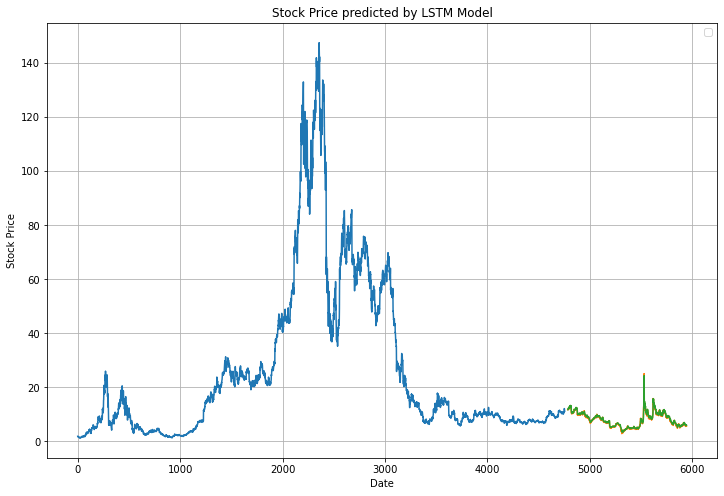

In [86]:
# plot test predictions


plt.figure(figsize=(12, 8))
plt.plot(close_df_train)
plt.plot(y_test[['close_price','pred']])
plt.legend(['Train', 'Val', 'Predictions'])
plt.xlabel('Date')
plt.ylabel('Stock Price')

plt.title("Stock Price predicted by LSTM Model")
plt.grid()
plt.legend()
plt.show()

# Using LSTM model to predict GOOGLE stock price

In [46]:
# Choose "Closed" price column as our input variable
close_df= gg_df['close_price']

data_len = round(len(close_df) * 0.8)

close_df_train = close_df.loc[close_df.index < data_len]
close_df_test = close_df.loc[close_df.index >= data_len]

print(close_df_train.head())
print()
print(close_df_test.head())

0    2.511011
1    2.710460
2    2.737738
3    2.624374
4    2.652653
Name: close_price, dtype: float64

3642    55.2955
3643    55.1190
3644    55.1060
3645    56.3790
3646    56.4315
Name: close_price, dtype: float64


In [47]:
# Scale the training data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_df_train.values.reshape(-1,1))
scaled_data.shape

(3642, 1)

In [48]:
# Use the previous 30 days 'close' price to predict the 31st day's price
previous_days = 30

In [49]:
# Splite data into X_train and y_train
X_train = []
y_train = []

for i in range(previous_days, len(scaled_data)):
    X_train.append(scaled_data[i-previous_days:i, 0])
    y_train.append(scaled_data[i, 0])

In [50]:
# Convert the X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(3612, 30)
(3612,)


In [51]:
# Reshape the X_train since LSTM needs 3-dimensional inputs
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3612, 30, 1)

In [52]:
# Build the LSTM model
model = Sequential()
# Add LSTM layer
model.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1],1)))
model.add(LSTM(units = 50, return_sequences=True))
model.add(LSTM(units = 50))
# prediction output layer
model.add(Dense(units=1))

In [53]:
# compile and train the data
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size =32, epochs=20)

Epoch 1/20
113/113 [==============================] - 9s 26ms/step - loss: 0.0069
Epoch 2/20
113/113 [==============================] - 3s 24ms/step - loss: 3.4358e-04
Epoch 3/20
113/113 [==============================] - 3s 25ms/step - loss: 3.1669e-04
Epoch 4/20
113/113 [==============================] - 3s 26ms/step - loss: 3.1795e-04
Epoch 5/20
113/113 [==============================] - 3s 26ms/step - loss: 3.4481e-04
Epoch 6/20
113/113 [==============================] - 3s 26ms/step - loss: 3.3414e-04
Epoch 7/20
113/113 [==============================] - 3s 26ms/step - loss: 3.0463e-04
Epoch 8/20
113/113 [==============================] - 3s 25ms/step - loss: 2.9627e-04
Epoch 9/20
113/113 [==============================] - 3s 26ms/step - loss: 2.7977e-04
Epoch 10/20
113/113 [==============================] - 3s 25ms/step - loss: 3.0017e-04
Epoch 11/20
113/113 [==============================] - 3s 25ms/step - loss: 2.8074e-04
Epoch 12/20
113/113 [==============================] - 3

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 50)            10400     
                                                                 
 lstm_4 (LSTM)               (None, 30, 50)            20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [55]:
#### Test model ####

# Scale the testing data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_test_data = scaler.fit_transform(close_df_test.values.reshape(-1,1))
scaled_test_data.shape

(911, 1)

In [56]:
# Create X_test and y_test
X_test = []
y_test = []

for i in range(previous_days, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-previous_days:i, 0])
    y_test.append(scaled_test_data[i, 0])

In [57]:
# Convert the X_test to numpy arrays
X_test = np.array(X_test)
print(X_test.shape)

(881, 30)


In [58]:
# reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)

(881, 30, 1)


In [59]:
# Predict the data

prediction = model.predict(X_test)
prediction = scaler.inverse_transform(prediction)

28/28 [==============================] - 1s 9ms/step


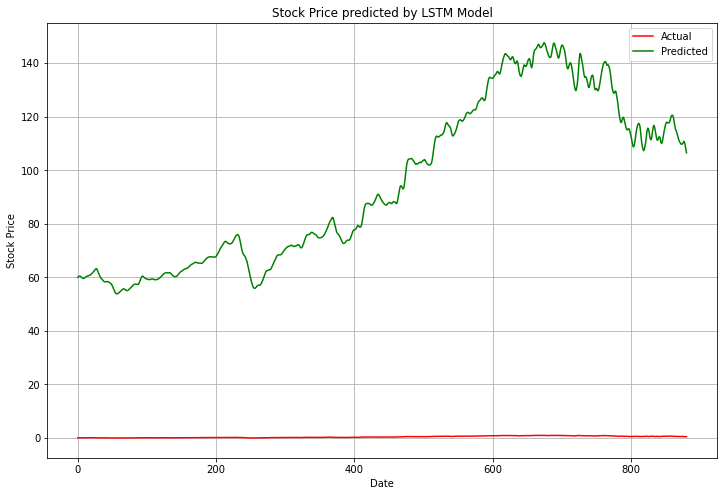

In [60]:
# plot test predictions

plt.figure(figsize=(12, 8))
plt.plot(y_test, color='red', label='Actual')
plt.plot(prediction, color='green', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')

plt.title("Stock Price predicted by LSTM Model")
plt.grid()
plt.legend()
plt.show()